# Dataset Building

Imports

In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

import unicodedata

## Lectura de los datos.

Datos extraídos de 879 partidos diferentes

In [2]:
df = pd.read_csv("data/all_shots.csv")

In [3]:
df.shape

(22673, 23)

In [4]:
df.head()

,period,minute,second,play_pattern,team,player,under_pressure,body_part,type,outcome,...,redirect,one_on_one,open_goal,deflected,start_location_x,start_location_y,end_location_x,end_location_y,end_location_z,defenders_between
0,1,2,29,Regular Play,Barcelona,Lionel Andrés Messi Cuccittini,NaN,Right Foot,Open Play,Off T,...,NaN,NaN,NaN,NaN,111.7,51.7,120.0,32.7,0.2,2.0
1,1,5,39,Regular Play,Barcelona,Jordi Alba Ramos,NaN,Left Foot,Open Play,Off T,...,NaN,NaN,NaN,NaN,114.0,27.0,120.0,35.0,0.9,1.0
2,1,15,28,From Keeper,Barcelona,Lionel Andrés Messi Cuccittini,NaN,Left Foot,Open Play,Saved,...,NaN,NaN,NaN,NaN,92.0,34.5,117.8,38.5,0.4,2.0
3,1,16,19,Regular Play,Deportivo Alavés,Rubén Sobrino Pozuelo,1.0,Head,Open Play,Off T,...,NaN,NaN,NaN,NaN,109.1,38.7,120.0,32.0,1.1,1.0
4,1,18,15,From Corner,Barcelona,Luis Alberto Suárez Díaz,NaN,Right Foot,Open Play,Off T,...,NaN,NaN,NaN,NaN,107.0,25.0,120.0,42.5,3.8,1.0


In [5]:
df.iloc[0,:]

period                                            1
minute                                            2
second                                           29
play_pattern                           Regular Play
team                                      Barcelona
player               Lionel Andrés Messi Cuccittini
under_pressure                                  NaN
body_part                                Right Foot
type                                      Open Play
outcome                                       Off T
technique                               Half Volley
first_time                                     True
follows_dribble                                 NaN
redirect                                        NaN
one_on_one                                      NaN
open_goal                                       NaN
deflected                                       NaN
start_location_x                              111.7
start_location_y                               51.7
end_location

In [6]:
df.columns

Index(['period', 'minute', 'second', 'play_pattern', 'team', 'player',
       'under_pressure', 'body_part', 'type', 'outcome', 'technique',
       'first_time', 'follows_dribble', 'redirect', 'one_on_one', 'open_goal',
       'deflected', 'start_location_x', 'start_location_y', 'end_location_x',
       'end_location_y', 'end_location_z', 'defenders_between'],
      dtype='object')

Total de goles en el dataset

In [7]:
df[df["outcome"]=="Goal"].shape

(2829, 23)

## Elección muestras

Para realizar el estudio únicamente se tendrán en cuenta los disparos de un equipo y sus jugadores, para ello, elegiremos aquel que tengan un mayor número de disparos. 

In [8]:
teams = df["team"].value_counts()
teams.head(20)

Barcelona                     7705
Chelsea FCW                    698
Manchester City WFC            680
Arsenal WFC                    599
Reading WFC                    488
Arsenal                        465
Real Madrid                    452
Everton LFC                    396
Birmingham City WFC            393
Brighton & Hove Albion WFC     367
West Ham United LFC            354
Liverpool WFC                  334
North Carolina Courage         329
Atlético Madrid                309
Sevilla                        277
Bristol City WFC               254
Valencia                       246
Manchester United              225
Athletic Bilbao                216
Real Sociedad                  210
Name: team, dtype: int64

In [9]:
players = df["player"].value_counts()
players.head(40)

Lionel Andrés Messi Cuccittini         2190
Luis Alberto Suárez Díaz                600
Andrés Iniesta Luján                    376
Neymar da Silva Santos Junior           354
Thierry Henry                           349
Xavier Hernández Creus                  316
Samuel Eto'o Fils                       304
Pedro Eliezer Rodríguez Ledesma         258
Daniel Alves da Silva                   226
Ivan Rakitić                            221
Ronaldo de Assis Moreira                220
David Villa Sánchez                     196
Vivianne Miedema                        192
Gerard Piqué Bernabéu                   181
Cristiano Ronaldo dos Santos Aveiro     141
Fara Williams                           132
Georgia Stanway                         124
Bethany England                         124
Alexis Alejandro Sánchez Sánchez        118
Philippe Coutinho Correia               115
Francesc Fàbregas i Soler               113
Antoine Griezmann                       104
Bojan Krkíc Pérez               

Con el fin de facilitar la limpieza y el tratamiento del dataset cogeremos únicamente las muestras que nos interesen. Por ello, cogeremos únicamente los 40 jugadores con más muestras y las muestras de un equipo como, por ejemplo, la Real Sociedad.

In [10]:
first40playersShots = df.groupby('player').filter(lambda x : (x['player'].count()>=69).any())
teamShots = df[df["team"] == "Real Sociedad"]

In [11]:
dataset = pd.concat([first40playersShots, teamShots])

In [12]:
dataset.shape

(8657, 23)

## Limpieza y creación del dataset

A continuación, se escogen aquellas variables que nos permitirán poder calcular el xG. Estas variables deben ser medidas antes del disparo para que puedan utilizarse correctamente. Además, se escogerá la variable 'outcome' para calcular si acaba en gol o no.

In [13]:
dataset = dataset[['player', 'team', 'body_part', 'type', 'outcome', 'technique',
        'under_pressure', 'follows_dribble', 'one_on_one','first_time',
        'start_location_x', 'start_location_y', 'defenders_between']].copy()

Transformamos las variables con los valores True y Nan a valores binarios 1 y 0.

In [14]:
binary_columns = ['under_pressure','first_time', 'follows_dribble',
                      'one_on_one']
for col in binary_columns:
    dataset.loc[:, col] = dataset.loc[:, col].replace(np.nan, 0)
    dataset.loc[:, col] = dataset.loc[:, col].replace(True, 1)
    dataset.loc[:, col] = dataset.loc[:, col].astype(int)

In [15]:
dataset['defenders_between'] = dataset['defenders_between'].astype('int')

Posibles valores de dichas variables

In [16]:
print(np.unique(dataset["outcome"]))
print(np.unique(dataset["body_part"]))
print(np.unique(dataset["type"]))
print(np.unique(dataset["technique"]))

['Blocked' 'Goal' 'Off T' 'Post' 'Saved' 'Saved Off Target'
 'Saved to Post' 'Wayward']
['Head' 'Left Foot' 'Other' 'Right Foot']
['Corner' 'Free Kick' 'Open Play' 'Penalty']
['Backheel' 'Diving Header' 'Half Volley' 'Lob' 'Normal' 'Overhead Kick'
 'Volley']


One hot encoding de las variables

In [17]:
one_hot_type = pd.get_dummies(dataset['type'])
dataset = pd.concat([dataset, one_hot_type], axis=1)
dataset.drop('type', axis=1, inplace=True)

In [18]:
one_hot_technique = pd.get_dummies(dataset['technique'])
dataset = pd.concat([dataset, one_hot_technique], axis=1)
dataset.drop('technique', axis=1, inplace=True)

Transformación de las columnas disparo con el pie derecho e izquierdo por disparo con la pierna preferida/hábil y menos hábil

In [19]:
one_hot_bodypart = pd.get_dummies(dataset['body_part'])
dataset = pd.concat([dataset, one_hot_bodypart], axis=1)
dataset.drop('body_part', axis=1, inplace=True)
dataset["preferred_foot"] = ""
dataset["not_preferred_foot"] = ""
df_players = pd.read_csv("data/players.csv")
df_players['long_name'] = df_players['long_name'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

for i,s in dataset.iterrows():
    if s["Head"]!=1 and s["Other"]!=1:
        if s["Right Foot"]==1:
            nombre_player = unicodedata.normalize("NFKD", s["player"]).encode("ascii","ignore").decode("ascii")
            player_row = df_players[df_players['long_name'].str.contains(nombre_player)].iloc[0]
            if player_row["preferred_foot"] == "Right":
                dataset.loc[i,"preferred_foot"] = 1
                dataset.loc[i,"not_preferred_foot"] = 0
            else:
                dataset.loc[i,"preferred_foot"] = 0
                dataset.loc[i,"not_preferred_foot"] = 1
        else: 
            nombre_player = unicodedata.normalize("NFKD", s["player"]).encode("ascii","ignore").decode("ascii")
            player_row = df_players[df_players['long_name'].str.contains(nombre_player)].iloc[0]
            if player_row["preferred_foot"] == "Left":
                dataset.loc[i,"preferred_foot"] = 1
                dataset.loc[i,"not_preferred_foot"] = 0
            else:
                dataset.loc[i,"preferred_foot"] = 0
                dataset.loc[i,"not_preferred_foot"] = 1
    else:
        dataset.loc[i,"preferred_foot"] = 0
        dataset.loc[i,"not_preferred_foot"] = 0
    
dataset.drop(['Left Foot', 'Right Foot'], axis=1, inplace=True)
dataset.loc[:, "preferred_foot"] = dataset.loc[:, "preferred_foot"].astype(int)
dataset.loc[:, "not_preferred_foot"] = dataset.loc[:, "not_preferred_foot"].astype(int)

A continuación, debido a que la posición (x, y) es relativa calcularemos la distancia a la portería y el ángulo de disparo donde en todos los disparos tendrá el mismo valor sin tener en cuenta la medidas de posición utilizadas en cada caso. 

Función que indica la distancia desde la posición de disparo al centro de la portería

In [20]:
def calculate_distance(location):
    porteria1 = [0, 40]
    porteria2 = [120, 40]
    d1 = math.sqrt(((location[0]-porteria1[0])**2)+((location[1]-porteria1[1])**2))
    d2 = math.sqrt(((location[0]-porteria2[0])**2)+((location[1]-porteria2[1])**2))
    return min(d1,d2)

dataset["distance"] = dataset.apply(lambda row: calculate_distance([row.start_location_x,row.start_location_y]),axis=1)

Función que calcula el ángulo de disparo

In [21]:
def calculate_angle(location):
    x=min((120-location[0]),(location[0]))
    y=(40-location[1])
    tan_angle = ((7.32*x)/((x**2)+(y**2)-((7.32/2)**2)))  #7.32 es el tamaño de la porteria
    angle = np.arctan(tan_angle) 
    if angle < 0:
        # para evitar ángulo negativos
        angle = 2*np.pi + angle

    return angle # en radianes

dataset["angle"] = dataset.apply(lambda row: calculate_angle([row.start_location_x,row.start_location_y]),axis=1)

In [22]:
dataset.drop(['start_location_x', 'start_location_y'], axis=1, inplace=True)

Creación del target (goal) según el valor de la variable 'outcome'

In [23]:
dataset["goal"] = dataset.apply(lambda row: 1 if row.outcome=="Goal" else 0,axis=1)

In [24]:
dataset.drop('outcome', axis=1, inplace=True)

Cambiamos el orden de las columnas tal como nos interesa

In [25]:
dataset = dataset[['player','team','distance', 'angle', 'under_pressure', 'follows_dribble', 'one_on_one',
       'first_time', 'defenders_between', 'Corner', 'Free Kick', 'Open Play', 'Penalty', 'Backheel', 
        'Diving Header', 'Half Volley', 'Lob', 'Normal', 'Overhead Kick', 'Volley', 'Head',
        'Other', 'preferred_foot', 'not_preferred_foot', 'goal']]

In [26]:
print("Number No goals",len(dataset[dataset.goal==0]))
print("Number goals",len(dataset[dataset.goal==1]))

Number No goals 7245
Number goals 1412


In [27]:
dataset

,player,team,distance,angle,under_pressure,follows_dribble,one_on_one,first_time,defenders_between,Corner,...,Half Volley,Lob,Normal,Overhead Kick,Volley,Head,Other,preferred_foot,not_preferred_foot,goal
0,Lionel Andrés Messi Cuccittini,Barcelona,14.345034,0.305893,0,0,0,1,2,0,...,1,0,0,0,0,0,0,0,1,0
1,Jordi Alba Ramos,Barcelona,14.317821,0.225330,0,0,0,1,1,0,...,0,0,0,0,1,0,0,1,0,0
2,Lionel Andrés Messi Cuccittini,Barcelona,28.535066,0.250549,0,0,0,0,2,0,...,0,0,1,0,0,0,0,1,0,0
4,Luis Alberto Suárez Díaz,Barcelona,19.849433,0.245001,0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
6,Ivan Rakitić,Barcelona,8.814193,0.738756,1,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22666,Raúl Rodríguez Navas,Real Sociedad,9.889894,0.662697,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
22668,Juan Miguel Jiménez López,Real Sociedad,19.501026,0.371031,0,0,0,1,4,0,...,1,0,0,0,0,0,0,1,0,0
22669,Asier Illarramendi Andonegi,Real Sociedad,31.308146,0.210353,1,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
22670,Juan Miguel Jiménez López,Real Sociedad,18.369812,0.364676,0,0,0,1,2,0,...,0,0,1,0,0,0,0,1,0,0


In [28]:
dataset.iloc[0,:]

player                Lionel Andrés Messi Cuccittini
team                                       Barcelona
distance                                   14.345034
angle                                       0.305893
under_pressure                                     0
follows_dribble                                    0
one_on_one                                         0
first_time                                         1
defenders_between                                  2
Corner                                             0
Free Kick                                          0
Open Play                                          1
Penalty                                            0
Backheel                                           0
Diving Header                                      0
Half Volley                                        1
Lob                                                0
Normal                                             0
Overhead Kick                                 

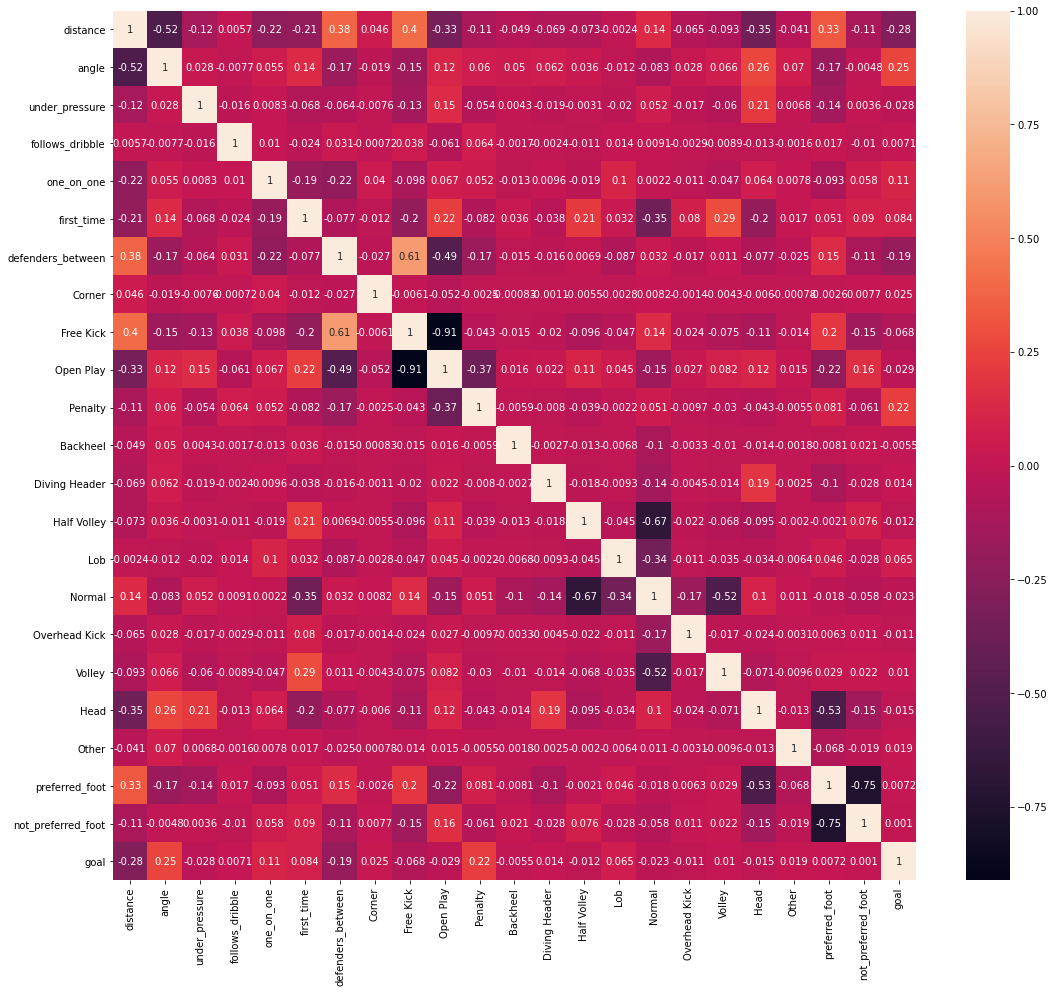

In [29]:
plt.figure(figsize=(18, 16))
correlation_mat = dataset.corr()
sns.heatmap(correlation_mat, annot = True)
plt.show()

Guardar dataset final

In [30]:
dataset.to_csv("data/dataset.csv", index=False)